In [29]:
import hashlib
import os
import tarfile
import zipfile
import requests


#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [30]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [31]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [58]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [59]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [60]:
print(train_data.shape)
print(test_data.shape)


(1460, 81)
(1459, 80)


In [61]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])


   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [62]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
#合并了训练数据和测试数据的特征列，训练数据从第二列到倒数第二列，测试数据从第二列到倒数第一列
print(all_features.iloc[0:5, [0, 1, 2, 3, -3, -2, -1]])


   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml
4          60       RL         84.0    14260    2008       WD        Normal


In [63]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 获取所有数值特征的索引
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 标准化数据
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [64]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True) # 将所有非数值特征转换为数值特征，one-hot编码
all_features.shape

(2919, 330)

In [66]:
print("=== 数据类型检查 ===")
print(all_features.dtypes.value_counts())

# 2. 确保所有数据都是数值类型
def convert_to_numeric(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            # 尝试转换为数值类型
            try:
                df[column] = pd.to_numeric(df[column])
            except:
                print(f"无法将列 {column} 转换为数值类型")
                # 如果无法转换，删除该列
                df.drop(column, axis=1, inplace=True)
    return df

# 3. 修改后的数据处理流程
# 处理数值特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
for feature in numeric_features:
    # 使用均值填充数值特征的nan
    mean_val = all_features[feature].mean()
    all_features[feature].fillna(mean_val, inplace=True)
    # 标准化
    if all_features[feature].std() != 0:
        all_features[feature] = (all_features[feature] - mean_val) / all_features[feature].std()

# 处理分类特征
categorical_features = all_features.dtypes[all_features.dtypes == 'object'].index
for feature in categorical_features:
    all_features[feature].fillna('None', inplace=True)

# 对分类特征进行独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)

# 确保所有数据都是浮点型
all_features = all_features.astype('float32')



# 1. 首先检查哪些特征列包含 nan
for column in all_features.columns:
    if all_features[column].isna().any():
        print(f"列 {column} 包含 {all_features[column].isna().sum()} 个 nan 值")

# 2. 分别处理数值特征和分类特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
categorical_features = all_features.dtypes[all_features.dtypes == 'object'].index

# 3. 处理数值特征
for feature in numeric_features:
    # 使用均值填充数值特征的nan
    mean_val = all_features[feature].mean()
    all_features[feature].fillna(mean_val, inplace=True)
    # 标准化
    if all_features[feature].std() != 0:
        all_features[feature] = (all_features[feature] - mean_val) / all_features[feature].std()

# 4. 处理分类特征
for feature in categorical_features:
    # 使用众数填充分类特征的nan
    mode_val = all_features[feature].mode()[0]
    all_features[feature].fillna(mode_val, inplace=True)

# 5. 对分类特征进行独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)

# 6. 再次检查是否还有nan值
print("处理后是否还有nan值:", all_features.isna().any().any())

# 7. 转换为tensor
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32) # 将训练数据的价格转换为tensor

# 8. 最后检查一次
print("最终检查:")
print("训练特征是否有nan:", torch.isnan(train_features).any())
print("训练标签是否有nan:", torch.isnan(train_labels).any())
print("特征最大值:", torch.max(train_features))
print("特征最小值:", torch.min(train_features))
print("标签最大值:", torch.max(train_labels))
print("标签最小值:", torch.min(train_labels))

=== 数据类型检查 ===
float64    310
bool        20
Name: count, dtype: int64
处理后是否还有nan值: False
最终检查:
训练特征是否有nan: tensor(False)
训练标签是否有nan: tensor(False)
特征最大值: tensor(54.0093)
特征最小值: tensor(-31.1716)
标签最大值: tensor(755000.)
标签最小值: tensor(34900.)


In [68]:
train_features.shape



torch.Size([1460, 330])

In [69]:
test_features.shape



torch.Size([1459, 330])

In [70]:
train_labels.shape


torch.Size([1460, 1])

In [71]:
loss = nn.MSELoss() #均方误差为损失函数
in_features = train_features.shape[1]  #in_features的值为330，也就是输入层有多少个神经元

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [72]:
def log_rmse(net, features, labels): #对数根误差函数
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    #net(features)是神经网络的输出,模型的预测
    #torch.clamp将预测值限制在1和无穷大之间
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    #torch.log(clipped_preds)和torch.log(labels)分别计算预测值和真实值的对数
    #torch.sqrt计算均方根误差
    #rmse.item()将均方根误差转换为Python标量
    return rmse.item()

In [73]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []  #创建两个空列表，用于存储训练和测试的损失
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),  #获取神经网络的可训练参数
                                 lr = learning_rate,   #学习率超参数
                                 weight_decay = weight_decay) #权重衰减超参数
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()  #梯度清零
            l = loss(net(X), y)   #计算损失
            l.backward()  #反向传播
            optimizer.step()  #更新参数
        train_ls.append(log_rmse(net, train_features, train_labels)) #将训练的损失添加到列表中
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels)) #将测试的损失添加到列表中
    return train_ls, test_ls

In [75]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        print(f'训练误差: {train_ls[-1]:.3f}')
        print(f'测试误差: {valid_ls[-1]:.3f}')
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

训练误差: 7.822
测试误差: 8.335
折1，训练log rmse7.822495, 验证log rmse8.334894
训练误差: 7.709
测试误差: 8.155
折2，训练log rmse7.709223, 验证log rmse8.155416
训练误差: 7.940
测试误差: 8.444
折3，训练log rmse7.939562, 验证log rmse8.443859
训练误差: 7.907
测试误差: 8.430
折4，训练log rmse7.907349, 验证log rmse8.430415
训练误差: 7.970
测试误差: 8.424
折5，训练log rmse7.969776, 验证log rmse8.423914
5-折验证: 平均训练log rmse: 7.869681, 平均验证log rmse: 8.357700


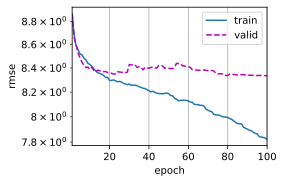

In [76]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')